https://www.mathworks.com/matlabcentral/answers/141137-how-can-i-compare-two-audio-files  - reference for sound comparisons using distance

In [21]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
!pip install SciencePlots
import scienceplots
plt.style.use(['science', 'notebook'])
import sympy as smp
from skimage import color
from skimage import io
from scipy.fft import fft, ifft, fft2, ifft2
from scipy.io import wavfile
from scipy import signal
from scipy.signal import periodogram as periodogram_f
from scipy.fft import fftfreq, fftshift

#all sound clips are converted to mono from stereo for analysis (except when generating the spectrograms)

In [22]:
#generate spectrogram manually/mathematically
import numpy as np
from matplotlib import pyplot as plt
import scipy.io.wavfile as wav
from numpy.lib import stride_tricks

""" short time fourier transform of audio signal """
def stft(sig, frameSize, overlapFac=0.5, window=np.hanning):
    win = window(frameSize)
    hopSize = int(frameSize - np.floor(overlapFac * frameSize))
    print(frameSize)
    print(hopSize)

    # zeros at beginning (thus center of 1st window should be for sample nr. 0)
    samples = np.append(np.zeros(int(np.floor(frameSize/2.0))), sig)
    print(len(samples))
    # cols for windowing
    cols = np.ceil( (len(samples) - frameSize) / float(hopSize)) + 1
    # zeros at end (thus samples can be fully covered by frames)
    samples = np.append(samples, np.zeros(frameSize))

    frames = stride_tricks.as_strided(samples, shape=(int(cols), frameSize), strides=(samples.strides[0]*hopSize, samples.strides[0])).copy()
    frames *= win

    return np.fft.rfft(frames)

""" scale frequency axis logarithmically """
def logscale_spec(spec, sr=44100, factor=20.):
    timebins, freqbins = np.shape(spec)

    scale = np.linspace(0, 1, freqbins) ** factor
    scale *= (freqbins-1)/max(scale)
    scale = np.unique(np.round(scale))

    # create spectrogram with new freq bins
    newspec = np.complex128(np.zeros([timebins, len(scale)]))
    for i in range(0, len(scale)):
        if i == len(scale)-1:
            newspec[:,i] = np.sum(spec[:,int(scale[i]):], axis=1)
        else:
            newspec[:,i] = np.sum(spec[:,int(scale[i]):int(scale[i+1])], axis=1)

    # list center freq of bins
    allfreqs = np.abs(np.fft.fftfreq(freqbins*2, 1./sr)[:freqbins+1])
    freqs = []
    for i in range(0, len(scale)):
        if i == len(scale)-1:
            freqs += [np.mean(allfreqs[int(scale[i]):])]
        else:
            freqs += [np.mean(allfreqs[int(scale[i]):int(scale[i+1])])]

    return newspec, freqs

""" plot spectrogram"""
def plotstft(audiopath, plotpath, binsize=2**8, colormap="jet"):
    samplerate, samples = wav.read(audiopath)
    print(samplerate)

    s = stft(samples, binsize)

    sshow, freq = logscale_spec(s, factor=1.0, sr=samplerate)

    ims = 20.*np.log10(np.abs(sshow)/10e-6) # amplitude to decibel

    timebins, freqbins = np.shape(ims)

    print("timebins: ", timebins)
    print("freqbins: ", freqbins)

    plt.figure(figsize=(15, 7.5))
    plt.title("Spectrogram of White noise 0.01", fontsize=20)
    plt.imshow(np.transpose(ims), origin="lower", aspect="auto", cmap=colormap, interpolation="none")
    plt.colorbar()

    plt.xlabel("time (s)", fontsize=20)
    plt.ylabel("frequency (hz)", fontsize=20)
    plt.xlim([0, timebins-1])
    plt.ylim([0, freqbins])

    xlocs = np.float32(np.linspace(0, timebins-1, 5))
    plt.xticks(xlocs, ["%.02f" % l for l in ((xlocs*len(samples)/timebins)+(0.5*binsize))/samplerate])
    ylocs = np.int16(np.round(np.linspace(0, freqbins-1, 10)))
    plt.yticks(ylocs, ["%.02f" % freq[i] for i in ylocs])

    if plotpath:
        plt.savefig(plotpath, bbox_inches="tight")
    else:
        plt.show()

    plt.clf()

    return ims

ims = plotstft('/content/drive/MyDrive/Sounds/exp 2/noise/White noise 0.01 amplitude.wav',
               '/content/drive/MyDrive/Sounds/exp 2/noise/White noise 0.01 amplitude.png')

/tmp/ipython-input-3764707721.py:56: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, samples = wav.read(audiopath)


44100
256
128
441128
timebins:  3446
freqbins:  129


<Figure size 1500x750 with 0 Axes>

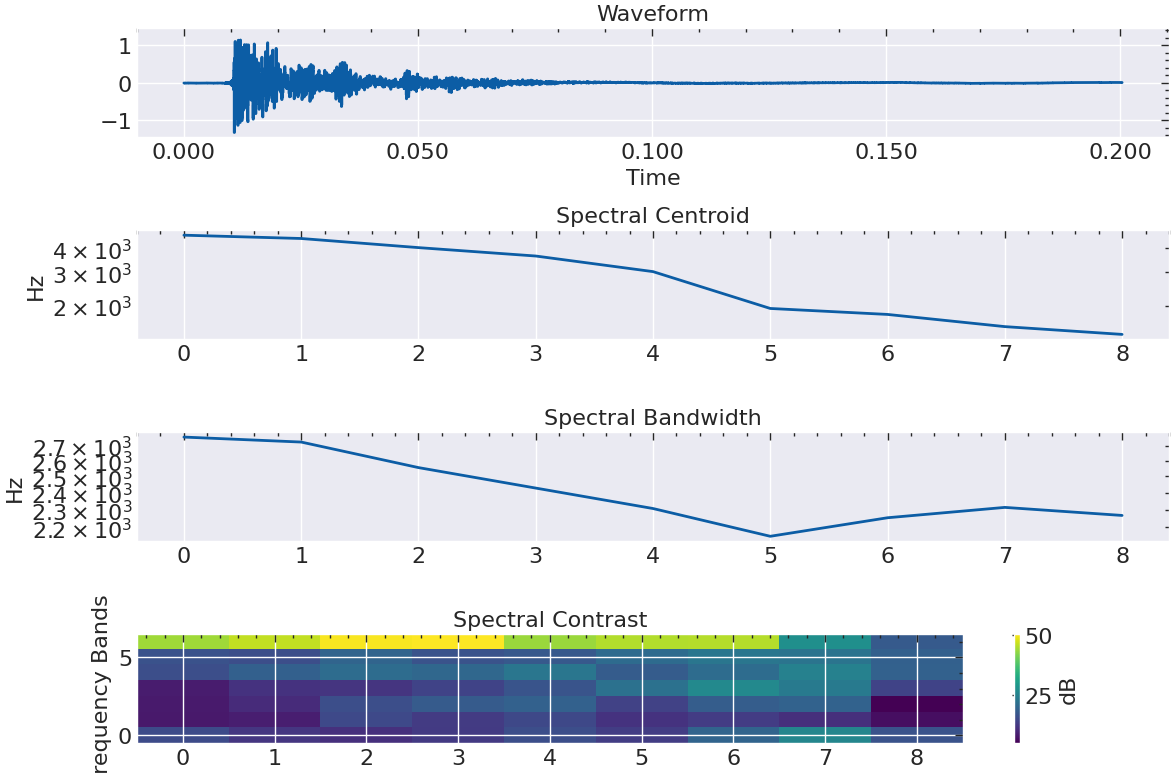

Spectral Centroid Shape: (1, 9)
Spectral Bandwidth Shape: (1, 9)
Spectral Contrast Shape: (7, 9)
Audio duration: 0.20045351473922904 seconds


In [19]:
#plotting spectral features of a particular sound clip

import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Load an audio file
y, sr = librosa.load('/content/drive/MyDrive/Sounds/Wood-Metal1-mono.wav')

# Compute features
spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

# Plot the waveform and features
plt.figure(figsize=(12, 8))

# Plot waveform
plt.subplot(4, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')

# Plot spectral centroid
plt.subplot(4, 1, 2)
plt.semilogy(spectral_centroid.T, label='Spectral Centroid')
plt.ylabel('Hz')
plt.title('Spectral Centroid')

# Plot spectral bandwidth
plt.subplot(4, 1, 3)
plt.semilogy(spectral_bandwidth.T, label='Spectral Bandwidth')
plt.ylabel('Hz')
plt.title('Spectral Bandwidth')

# Plot spectral contrast
plt.subplot(4, 1, 4)
plt.imshow(spectral_contrast, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='dB')
plt.title('Spectral Contrast')
plt.ylabel('Frequency Bands')

plt.tight_layout()
plt.show()

# Print feature shapes for reference
print(f"Spectral Centroid Shape: {spectral_centroid.shape}")
print(f"Spectral Bandwidth Shape: {spectral_bandwidth.shape}")
print(f"Spectral Contrast Shape: {spectral_contrast.shape}")
print(f"Audio duration: {len(y) / sr} seconds")


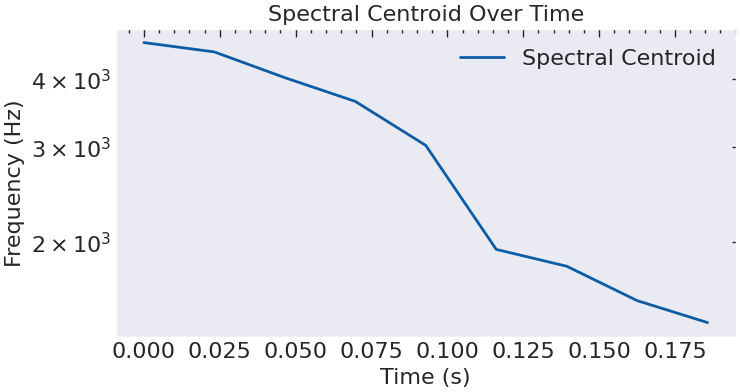

Audio duration: 0.20045351473922904 seconds


In [20]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load the audio clip (ensure it's 0.20 seconds long)
y, sr = librosa.load('/content/drive/MyDrive/Sounds/Wood-Metal1-mono.wav')

# Compute spectral centroid
centroid = librosa.feature.spectral_centroid(y=y, sr=sr)

# Convert frame indices to time
times = librosa.frames_to_time(range(centroid.shape[1]), sr=sr)

# Plot the spectral centroid with correct time scaling
plt.figure(figsize=(8, 4))
plt.semilogy(times, centroid[0], label='Spectral Centroid')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectral Centroid Over Time')
plt.legend()
plt.grid()
plt.show()

# Confirm the duration of the audio
print(f"Audio duration: {len(y) / sr} seconds")

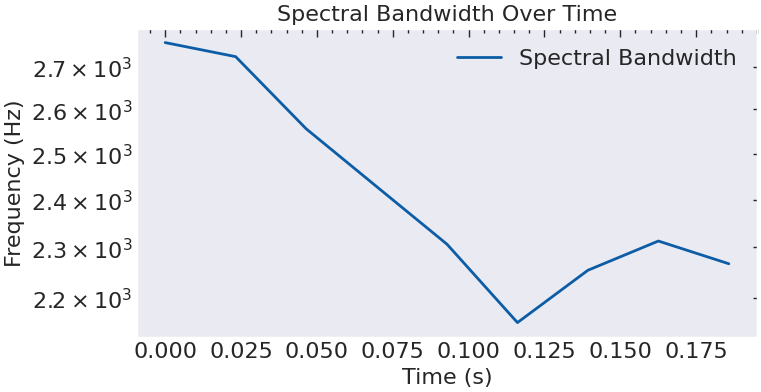

Audio duration: 0.200 seconds


In [23]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load the audio clip (ensure it's short, e.g., 0.20 seconds)
y, sr = librosa.load('/content/drive/MyDrive/Sounds/Wood-Metal1-mono.wav')

# Compute spectral bandwidth
bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)

# Convert frame indices to time
times = librosa.frames_to_time(range(bandwidth.shape[1]), sr=sr)

# Plot the spectral bandwidth
plt.figure(figsize=(8, 4))
plt.semilogy(times, bandwidth[0], label='Spectral Bandwidth')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectral Bandwidth Over Time')
plt.legend(loc='upper right')
plt.grid()
plt.show()

# Confirm the duration of the audio
print(f"Audio duration: {len(y) / sr:.3f} seconds")

In [24]:
import librosa
import numpy as np
from scipy.spatial.distance import euclidean

# Load two audio files
y1, sr1 = librosa.load('/content/drive/MyDrive/Sounds/Glass-Metal1-mono.wav')
y2, sr2 = librosa.load('/content/drive/MyDrive/Sounds/Wood-Metal1-mono.wav')

# Compute features for each sound
centroid1 = librosa.feature.spectral_centroid(y=y1, sr=sr1).mean()
bandwidth1 = librosa.feature.spectral_bandwidth(y=y1, sr=sr1).mean()
contrast1 = librosa.feature.spectral_contrast(y=y1, sr=sr1).mean(axis=1)  # Multi-band

centroid2 = librosa.feature.spectral_centroid(y=y2, sr=sr2).mean()
bandwidth2 = librosa.feature.spectral_bandwidth(y=y2, sr=sr2).mean()
contrast2 = librosa.feature.spectral_contrast(y=y2, sr=sr2).mean(axis=1)

# Combine features into vectors
features1 = [centroid1, bandwidth1] + list(contrast1)
features2 = [centroid2, bandwidth2] + list(contrast2)

# Compute similarity/distance
distance = euclidean(features1, features2)
print(f"Euclidean Distance between the two sounds: {distance:.2f}")
print(centroid1)
print(features1)

Euclidean Distance between the two sounds: 697.84
3639.5180319485603
[np.float64(3639.5180319485603), np.float64(2541.0870483389135), np.float64(13.951934834601076), np.float64(11.10385528404896), np.float64(15.810695921282578), np.float64(18.34790107371695), np.float64(22.368255775501748), np.float64(22.65000543953387), np.float64(41.84944609612738)]


In [25]:
import librosa
import librosa.display
import numpy as np

# Load the audio file
y, sr = librosa.load('/content/drive/MyDrive/Sounds/Glass-Metal1-mono.wav')

# Compute the spectrogram and spectral contrast
S = np.abs(librosa.stft(y))  # Compute the magnitude spectrogram
contrast = librosa.feature.spectral_contrast(S=S, sr=sr)

# Get the frequency bands
freq_bins = librosa.fft_frequencies(sr=sr)  # All FFT frequency bins
band_edges = librosa.feature.spectral_contrast(S=S, sr=sr, fmin=sr/2**8).shape

print("The band edges in hertz for spectral contrast:",band_edges)

The band edges in hertz for spectral contrast: (7, 9)


In [26]:
import librosa
import numpy as np

# Load audio
y, sr = librosa.load('/content/drive/MyDrive/Sounds/Glass-Metal1-mono.wav')

# Compute spectrogram
S = np.abs(librosa.stft(y))

# Get the spectral contrast
contrast = librosa.feature.spectral_contrast(S=S, sr=sr)

# Compute the band edges (frequency bands in Hz)
num_bands = contrast.shape[0]  # Number of bands
fmin = librosa.note_to_hz('C1')  # Lowest frequency for contrast computation (~32.7 Hz by default)
fmax = sr / 2  # Nyquist frequency
band_edges = np.geomspace(fmin, fmax, num=num_bands + 1)

# Print band edges
print(f"Frequency band edges (Hz): {band_edges}")
print(fmax)

Frequency band edges (Hz): [   32.70319566    75.11087514   172.51046723   396.21241599
   909.99857054  2090.03394381  4800.27334956 11025.        ]
11025.0


In [27]:
import librosa
import numpy as np
from scipy.spatial.distance import euclidean

# List of sound file paths
sound_files = ['/content/drive/MyDrive/Sounds/exp 2/plastic rod/Glass-Plastic1.wav',
               '/content/drive/MyDrive/Sounds/exp 2/plastic rod/Glass-Plastic2.wav',
               '/content/drive/MyDrive/Sounds/exp 2/plastic rod/Metal-Plastic1.wav',
               '/content/drive/MyDrive/Sounds/exp 2/plastic rod/Metal-Plastic2.wav',
               '/content/drive/MyDrive/Sounds/exp 2/plastic rod/Plastic-Plastic1.wav',
               '/content/drive/MyDrive/Sounds/exp 2/plastic rod/Plastic-Plastic2.wav',
               '/content/drive/MyDrive/Sounds/exp 2/plastic rod/Wood-Plastic1.wav',
               '/content/drive/MyDrive/Sounds/exp 2/plastic rod/Wood-Plastic2.wav']

# Function to extract features
def extract_features(audio_path):
    y, sr = librosa.load(audio_path)
    # Compute features
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr).mean()
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr).mean(axis=1)  # Multi-band contrast
    # Combine features into a single vector
    return [centroid, bandwidth] + list(contrast)

# Extract features for all sounds
features = [extract_features(sound) for sound in sound_files]

# Compute distance matrix
num_sounds = len(features)
distance_matrix = np.zeros((num_sounds, num_sounds))

for i in range(num_sounds):
    for j in range(num_sounds):
        distance_matrix[i, j] = euclidean(features[i], features[j])

# Display the distance matrix
import pandas as pd
distance_df = pd.DataFrame(distance_matrix, columns=sound_files, index=sound_files)

distance_df.rename(columns={"/content/drive/MyDrive/Sounds/exp 2/plastic rod/Glass-Plastic1.wav": "Glass-Plastic1",
                            "/content/drive/MyDrive/Sounds/exp 2/plastic rod/Glass-Plastic2.wav": "Glass-Plastic2",
                            "/content/drive/MyDrive/Sounds/exp 2/plastic rod/Metal-Plastic1.wav": "Metal-Plastic1",
                            "/content/drive/MyDrive/Sounds/exp 2/plastic rod/Metal-Plastic2.wav": "Metal-Plastic2",
                            "/content/drive/MyDrive/Sounds/exp 2/plastic rod/Plastic-Plastic1.wav": "Plastic-Plastic1",
                            "/content/drive/MyDrive/Sounds/exp 2/plastic rod/Plastic-Plastic2.wav": "Plastic-Plastic2",
                            "/content/drive/MyDrive/Sounds/exp 2/plastic rod/Wood-Plastic1.wav": "Wood-Plastic1",
                            "/content/drive/MyDrive/Sounds/exp 2/plastic rod/Wood-Plastic2.wav": "Wood-Plastic2"}, inplace = True)

lst = ["Glass-Plastic1", "Glass-Plastic2",
       "Metal-Plastic1", "Metal-Plastic2",
       "Plastic-Plastic1", "Plastic-Plastic2",
       "Wood-Plastic1", "Wood-Plastic2"]

distance_df[" "] = lst
distance_df.set_index(" ", inplace=True)
distance_df = distance_df.round(2)
distance_df

,Glass-Plastic1,Glass-Plastic2,Metal-Plastic1,Metal-Plastic2,Plastic-Plastic1,Plastic-Plastic2,Wood-Plastic1,Wood-Plastic2
,,,,,,,,
Glass-Plastic1,0.00,743.97,454.37,425.60,361.92,298.30,899.06,941.13
Glass-Plastic2,743.97,0.00,296.02,344.90,412.13,680.23,301.03,282.58
Metal-Plastic1,454.37,296.02,0.00,64.33,187.18,460.73,519.10,536.81
Metal-Plastic2,425.60,344.90,64.33,0.00,216.99,473.72,581.55,596.49
Plastic-Plastic1,361.92,412.13,187.18,216.99,0.00,279.81,537.27,580.19
Plastic-Plastic2,298.30,680.23,460.73,473.72,279.81,0.00,733.60,794.22
Wood-Plastic1,899.06,301.03,519.10,581.55,537.27,733.60,0.00,80.37
Wood-Plastic2,941.13,282.58,536.81,596.49,580.19,794.22,80.37,0.00


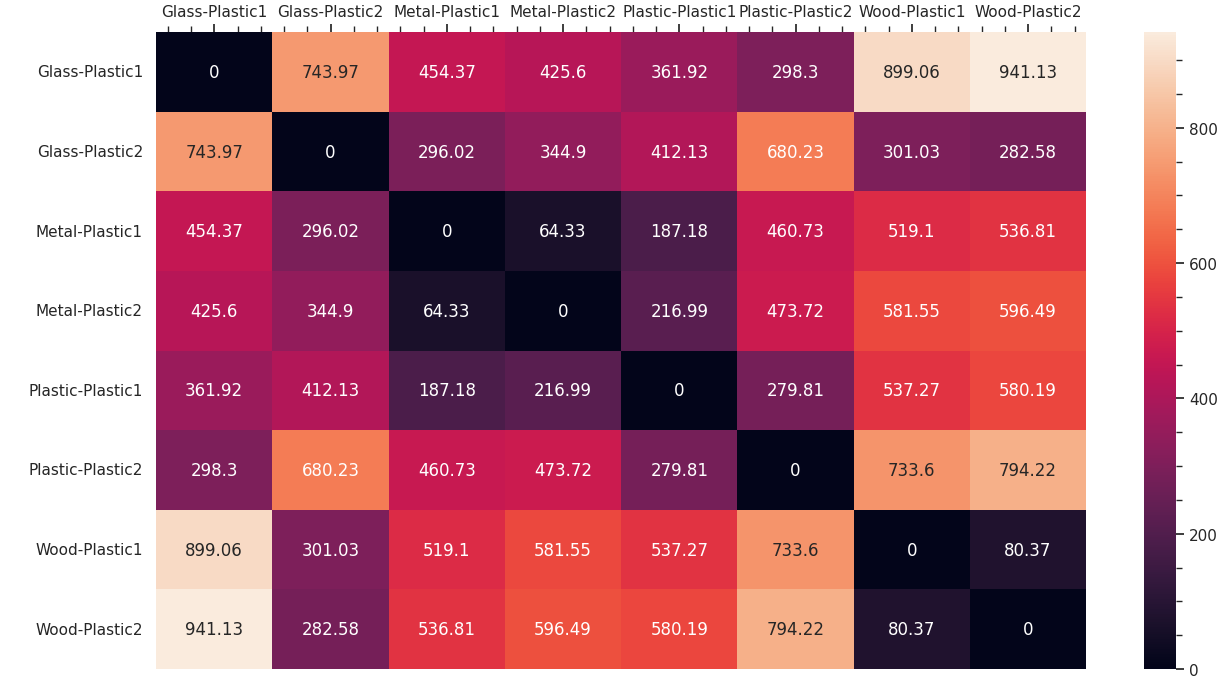

In [28]:
import seaborn as sns
sns.set_theme(rc={'figure.figsize':(15,8.27)})

ax = sns.heatmap(distance_df, annot=True,  fmt='g')
ax.xaxis.tick_top()
fig = ax.get_figure()
fig.savefig("out3.png")



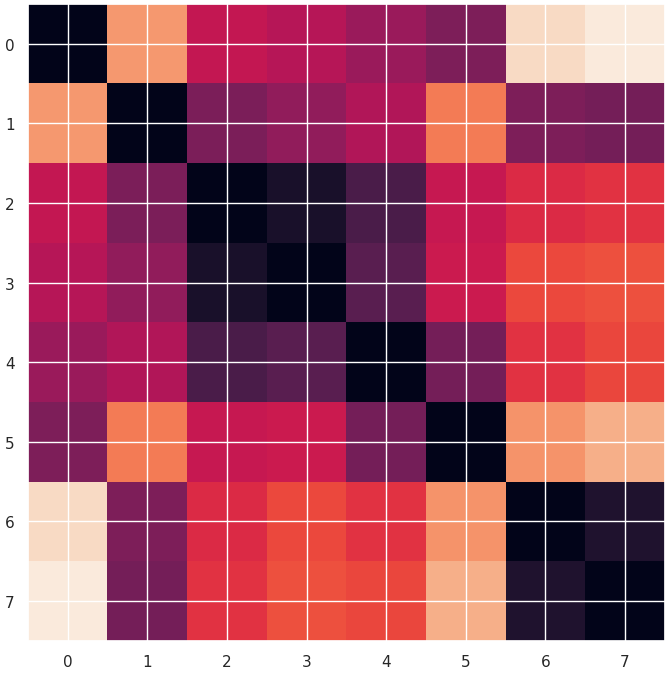

In [29]:
plt.imshow(distance_df)

In [30]:
import librosa
import numpy as np
from scipy.spatial.distance import euclidean

files = ['/content/drive/MyDrive/Sounds/exp 2/plastic rod/Glass-Plastic1.wav',
         '/content/drive/MyDrive/Sounds/exp 2/plastic rod/Glass-Plastic2.wav',
         '/content/drive/MyDrive/Sounds/exp 2/plastic rod/Metal-Plastic1.wav',
         '/content/drive/MyDrive/Sounds/exp 2/plastic rod/Metal-Plastic2.wav',
         '/content/drive/MyDrive/Sounds/exp 2/plastic rod/Plastic-Plastic1.wav',
         '/content/drive/MyDrive/Sounds/exp 2/plastic rod/Plastic-Plastic2.wav',
         '/content/drive/MyDrive/Sounds/exp 2/plastic rod/Wood-Plastic1.wav',
         '/content/drive/MyDrive/Sounds/exp 2/plastic rod/Wood-Plastic2.wav']

y = [librosa.load(f)[0] for f in files]
sr = [librosa.load(f)[1] for f in files]

centroid = []
bandwidth = []
contrast = []
features = []

for i in range (8):
  centroid.append(float(librosa.feature.spectral_centroid(y=y[i], sr=sr[i]).mean()))
  bandwidth.append(float(librosa.feature.spectral_bandwidth(y=y[i], sr=sr[i]).mean()))
  cont = librosa.feature.spectral_contrast(y=y[i], sr=sr[i]).mean(axis=1)
  contrast.append([float(x) for x in cont])
  features.append([centroid[i], bandwidth[i]] + list(contrast[i]))

'''
# Combine features into vectors
features1 = [centroid[0], bandwidth[0]] + list(contrast[0])
features2 = [centroid[1], bandwidth[1]] + list(contrast[1])

# Compute similarity/distance
distance = euclidean(features1, features2)
print(f"Euclidean Distance between the two sounds: {distance:.2f}")
'''
#print(features[0])
#print(features[1])

df_features = pd.DataFrame()
df_features['Glass-Plastic1'] = features[0]
df_features['Glass-Plastic2'] = features[1]
df_features['Metal-Plastic1'] = features[2]
df_features['Metal-Plastic2'] = features[3]
df_features['Plastic-Plastic1'] = features[4]
df_features['Plastic-Plastic2'] = features[5]
df_features['Wood-Plastic1'] = features[6]
df_features['Wood-Plastic2'] = features[7]


lst =  ['Mean Centroid (Hz)', 'Mean bandwidth (Hz)', 'Spectral contrast (dB) in band 1', 'Spectral contrast (dB) in band 2',
        'Spectral contrast (dB) in band 3', 'Spectral contrast (dB) in band 4','Spectral contrast (dB) in band 5',
        'Spectral contrast (dB) in band 6', 'Spectral contrast (dB) in band 7']
df_features['Index'] = lst
df_features.set_index('Index', inplace=True)

df_features

,Glass-Plastic1,Glass-Plastic2,Metal-Plastic1,Metal-Plastic2,Plastic-Plastic1,Plastic-Plastic2,Wood-Plastic1,Wood-Plastic2
Index,,,,,,,,
Mean Centroid (Hz),3566.369168,2853.225517,3119.657247,3141.391626,3265.166123,3528.230839,2827.187925,2754.944533
Mean bandwidth (Hz),2590.902064,2379.014929,2507.982844,2568.473511,2390.316791,2295.125747,2079.151894,2114.133360
Spectral contrast (dB) in band 1,14.660835,16.314733,13.933904,12.356486,12.936482,11.326396,16.264757,14.692337
Spectral contrast (dB) in band 2,12.775832,11.767364,11.511438,12.336144,10.613615,9.379662,11.413083,11.047840
Spectral contrast (dB) in band 3,17.770716,19.148660,19.187594,19.087102,16.215803,17.464444,16.062777,15.451242
Spectral contrast (dB) in band 4,18.521362,20.219392,20.676941,21.435628,20.599336,19.401272,21.510977,20.602207
Spectral contrast (dB) in band 5,19.361553,22.272749,23.040166,23.133671,21.272740,19.689408,20.882772,20.427646
Spectral contrast (dB) in band 6,22.411402,20.221618,20.401009,21.778823,19.200604,19.687643,19.018447,22.507227
Spectral contrast (dB) in band 7,42.478891,43.119022,43.767005,42.498089,41.738484,45.900953,40.266749,41.194319


In [31]:
transposed_df = df_features.transpose()
transposed_df

Index,Mean Centroid (Hz),Mean bandwidth (Hz),Spectral contrast (dB) in band 1,Spectral contrast (dB) in band 2,Spectral contrast (dB) in band 3,Spectral contrast (dB) in band 4,Spectral contrast (dB) in band 5,Spectral contrast (dB) in band 6,Spectral contrast (dB) in band 7
Glass-Plastic1,3566.369168,2590.902064,14.660835,12.775832,17.770716,18.521362,19.361553,22.411402,42.478891
Glass-Plastic2,2853.225517,2379.014929,16.314733,11.767364,19.148660,20.219392,22.272749,20.221618,43.119022
Metal-Plastic1,3119.657247,2507.982844,13.933904,11.511438,19.187594,20.676941,23.040166,20.401009,43.767005
Metal-Plastic2,3141.391626,2568.473511,12.356486,12.336144,19.087102,21.435628,23.133671,21.778823,42.498089
Plastic-Plastic1,3265.166123,2390.316791,12.936482,10.613615,16.215803,20.599336,21.272740,19.200604,41.738484
Plastic-Plastic2,3528.230839,2295.125747,11.326396,9.379662,17.464444,19.401272,19.689408,19.687643,45.900953
Wood-Plastic1,2827.187925,2079.151894,16.264757,11.413083,16.062777,21.510977,20.882772,19.018447,40.266749
Wood-Plastic2,2754.944533,2114.133360,14.692337,11.047840,15.451242,20.602207,20.427646,22.507227,41.194319
